# Garbage Classification using MobilenetV2

# Import Required Libraries

In [4]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.mobilenet_v2 as mobilenetv2

In [6]:
# Define Constants

In [7]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery', 6: 'clothes', 7: 'green-glass', 8: 'brown-glass', 9: 'white-glass',
              10: 'biological'}

print('defining constants successful!')

defining constants successful!


# Create DataFrame

We want to create a data frame that has in one column the filenames of all our images and in the other column the corresponding category. 
We Open the directories in the dataset one by one, save the filenames in the filenames_list and add the corresponding category in the categories_list

In [48]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: (x[:re.search("[1234567890]",x).start()] + '/' + x))
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')
print(df)

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

AttributeError: 'NoneType' object has no attribute 'start'

In [ ]:
df.head()

In [ ]:
# see sample image, you can run the same cell again to get a different image
arr_img = []
for i in range(25):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    randomimage = image.load_img(base_path +sample['filename'])
    arr_img.append(randomimage)

plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(25):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(arr_img[i])

plt.show()


# Viusalize the Categories Distribution

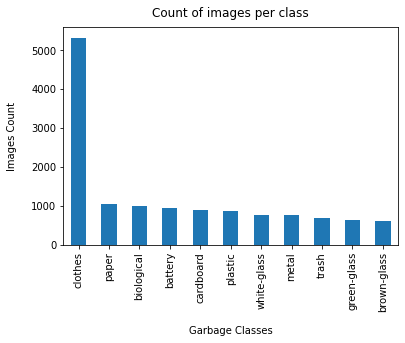

In [42]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# Create the model

In [40]:
mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'mobilenet-v2-keras-weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 11)                14091     
                                                                 
Total params: 2272075 (8.67 MB)
Trainable params: 14091 (55.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


We will use the EarlyStopping call back to stop our training if the validation_accuray is not improving for a certain number of epochs.

In [10]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


# Split the Data Set

In [43]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1354 validate size =  1354 test size =  1354


# Train the model

In [44]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


/cluster/2024eli/.local/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 10831 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [45]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


/cluster/2024eli/.local/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1354 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
EPOCHS = 20
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

In [ ]:
model.save_weights("model12.h5")

In [ ]:
model.save("model_custom.h5")

# Visualize the training process


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Evaluate the test

To evaluate the performance of our model we will create a test generator to load the images from the input data directory and evaluate the results.

In [46]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 0 validated image filenames belonging to 0 classes.


/cluster/2024eli/.local/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1354 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [8]:
import tensorflow as tf
import tflite_runtime.interpreter as tflite
from keras.models import load_model
import numpy as np

model = load_model("model_custom.h5")

In [9]:
filenames = test_generator.filenames
nb_samples = len(filenames)

# _, accuracy = model.evaluate_generator(test_generator, nb_samples)
_, accuracy = model.evaluate(test_generator)

print('Accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

NameError: name 'test_generator' is not defined

In [ ]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model 
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

In [10]:
# get the model's predictions for the test set
    
preds = model.predict(test_generator)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

NameError: name 'test_generator' is not defined

In [11]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

model1 = load_model('model_custom.h5')

1/1 [==============================] - 1s 1s/step
[[4.4456500e-04 5.6582550e-04 3.1008955e-02 1.8080344e-05 3.6240713e-04
  9.5866650e-01 4.5858123e-04 4.9240312e-05 4.7788839e-03 1.6328497e-05
  3.6306249e-03]]
predicted class is green-glass with probability 0.9586665


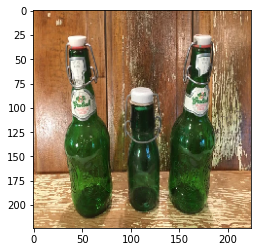

In [15]:
img = image.load_img("greenglass.jpg", target_size = IMAGE_SIZE)
plt.imshow(img)
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

preds = model1.predict(img)
print(preds)
rev_dict = {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'trash', 10: 'white-glass'}

for i, p in enumerate(preds):
    index=np.argmax(p)
    klass=rev_dict[index]    
    prob=p[index]
    print('predicted class is', klass,'with probability',prob)

1/1 [==============================] - 0s 54ms/step


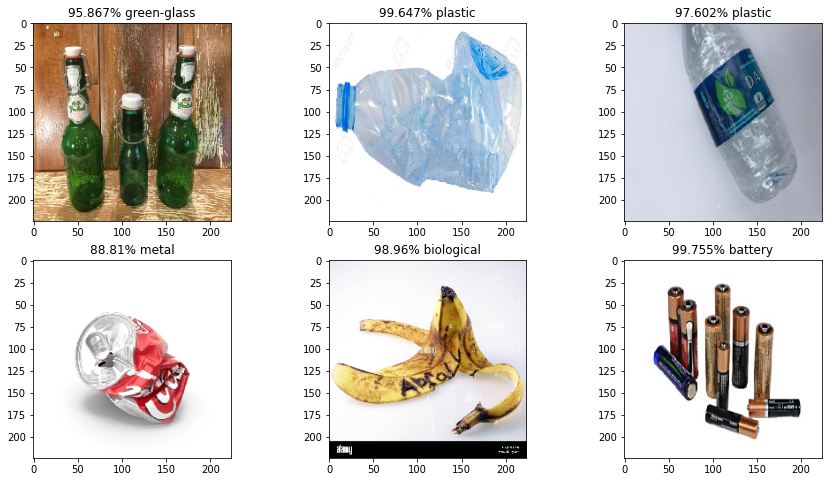

In [37]:
def params(size):
    max = int(size**0.5)
    possible_sizes = [(i, size//i) for i in range(1, max+1) if size % i == 0]
    width, height = min(possible_sizes, key=lambda x: abs(x[0] - size/x[0]))
    if width > height: width, height = height, width
    return width, height

arr_img = []
arr_prob = []
images = ["greenglass.jpg", "bottle.jpg", "bottlefromtrain.jpg", "sodacan.jpg", "bananapeel.jpg", "batteries.jpg"]
for i in images:
    img = image.load_img(i, target_size = IMAGE_SIZE)
    arr_img.append(img)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    preds = model1.predict(img)
    rev_dict = {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'trash', 10: 'white-glass'}

    for i, p in enumerate(preds):
        index=np.argmax(p)
        klass=rev_dict[index]    
        prob=p[index]
        arr_prob.append((prob, klass))

plt.figure(figsize=(15,8)) # specifying the overall grid size

for i in range(len(images)):
    plt.subplot(*params(len(images)),i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(arr_img[i])
    plt.title(f"{round(arr_prob[i][0]*100, 3)}% {arr_prob[i][1]}")

plt.show()